In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [41]:
# https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
# https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
# https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/

In [42]:
data = pd.read_csv('datatest2.txt')
data.head(5)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-11 14:48:00,21.7600,31.133333,437.333333,1029.666667,0.005021,1
2,2015-02-11 14:49:00,21.7900,31.000000,437.333333,1000.000000,0.005009,1
3,2015-02-11 14:50:00,21.7675,31.122500,434.000000,1003.750000,0.005022,1
4,2015-02-11 14:51:00,21.7675,31.122500,439.000000,1009.500000,0.005022,1
5,2015-02-11 14:51:59,21.7900,31.133333,437.333333,1005.666667,0.005030,1


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9752 non-null   object 
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB


In [44]:
def toOrdinalDate(column):
    arr=[]
    for date in column:
        time=pd.Timestamp(date)
        time=time.toordinal()
        arr.append(time)
    return pd.DataFrame(np.array(arr), index=data.index)
data['date'] = toOrdinalDate(data['date'].to_numpy())

In [45]:
def rescaling(dfColumn):
    feature = dfColumn.to_numpy().reshape(-1, 1)
    minmax_scale = StandardScaler()
    scaled_feature = minmax_scale.fit_transform(feature)
    return pd.Series(scaled_feature.reshape(-1), index=data.index)

for column in data:
    if column != 'Occupancy':
        data[column] = rescaling(data[column])


In [46]:
data.head(5)
data['Occupancy'] = data['Occupancy'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           9752 non-null   float64
 1   Temperature    9752 non-null   float64
 2   Humidity       9752 non-null   float64
 3   Light          9752 non-null   float64
 4   CO2            9752 non-null   float64
 5   HumidityRatio  9752 non-null   float64
 6   Occupancy      9752 non-null   float64
dtypes: float64(7)
memory usage: 609.5 KB


## Izvlacenje klasne kolone od nezavisnih atributa

In [47]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,0:6]
Y = data.iloc[:,-1]
#print(X)
#print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Funkcija za proveru i prikaz rezultata
Podaci koje je moguce izvuci iz history callback-a su:<br>
['accuracy', 'loss', 'val_accuracy', 'val_loss']

In [48]:
def print_result(model):
    model.evaluate(X_test, Y_test)[1]
    #-----------------------------------------------
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    #------------------------------------------------
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    #------------------------------------------------
#     y_pred = model.predict(X_test)
#     y_pred = (y_pred > 0.5)
#     confusion_matrix = (Y_test, y_pred)

In [49]:
BATCH_SIZE=100
EPOCHS=30
INPUT_DIM=6
NODES1=16
NODES2=16


In [50]:
_EPSILON = K.epsilon()
def custom_loss(y_true, y_pred):
    #squared_difference = tf.square(y_true - y_pred)
    #return -tf.sum([y_true[i]*log2(y_pred[i]) for i in range(len(y_true))])
    #return tf.reduce_mean(squared_difference, axis=-1)
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -(y_true * K.log(y_pred) + (1.0 - y_true) * K.log(1.0 - y_pred))
    return K.mean(out, axis=-1)

## Definisanje i treniranje modela

In [51]:
network = Sequential()
network.add(Dense(NODES1, activation="relu", input_dim=INPUT_DIM))
network.add(Dense(NODES2,activation="relu"))
network.add(Dense(1, activation="sigmoid"))

network.compile(optimizer='sgd', 
                loss=custom_loss, 
                metrics=['accuracy'])

hist = network.fit(X_train, Y_train, 
                   batch_size=BATCH_SIZE, epochs=EPOCHS, 
                   validation_data=(X_test, Y_test))

network.summary()

Epoch 1/30
79/79 [==============================] - 3s 14ms/step - loss: 0.6931 - accuracy: 0.4549 - val_loss: 0.5804 - val_accuracy: 0.8324
Epoch 2/30
79/79 [==============================] - 1s 7ms/step - loss: 0.5563 - accuracy: 0.8321 - val_loss: 0.4867 - val_accuracy: 0.8426
Epoch 3/30
79/79 [==============================] - 1s 8ms/step - loss: 0.4658 - accuracy: 0.8407 - val_loss: 0.4059 - val_accuracy: 0.8642
Epoch 4/30
79/79 [==============================] - 1s 7ms/step - loss: 0.3864 - accuracy: 0.8697 - val_loss: 0.3294 - val_accuracy: 0.9124
Epoch 5/30
79/79 [==============================] - 1s 7ms/step - loss: 0.3178 - accuracy: 0.9059 - val_loss: 0.2638 - val_accuracy: 0.9370
Epoch 6/30
79/79 [==============================] - 1s 7ms/step - loss: 0.2504 - accuracy: 0.9324 - val_loss: 0.2123 - val_accuracy: 0.9590
Epoch 7/30
79/79 [==============================] - 1s 7ms/step - loss: 0.1987 - accuracy: 0.9597 - val_loss: 0.1744 - val_accuracy: 0.9657
Epoch 8/30
79/79 [=

61/61 [==============================] - 0s 4ms/step - loss: 0.0505 - accuracy: 0.9892


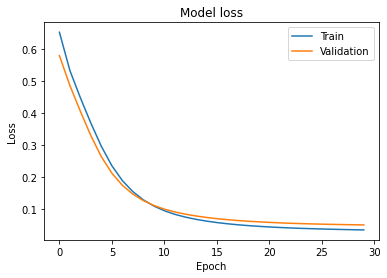

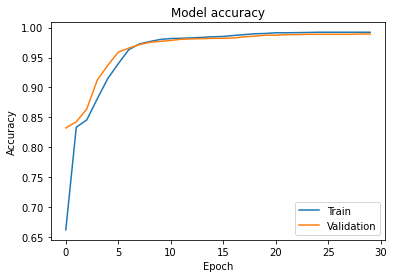

In [52]:
print_result(network)

## Koriscenje squared_hinge loss funkcije

In [53]:
# promena vrednosti klasa {0,1} na {-1,1}
yHinge = Y
yHinge.replace({0: -1})

X_trainH, X_testH, Y_trainH, Y_testH = train_test_split(X, yHinge, test_size=0.2, random_state=1)

X_trainH, X_valH, Y_trainH, Y_valH = train_test_split(X_trainH, Y_trainH, test_size=0.2, random_state=1)

# radi dobro kada je u poslednjem sloju tanh aktivaciona funkcija
classifier2 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='tanh'),])

classifier2.compile(optimizer='sgd',  
                    loss='squared_hinge', 
                    metrics=['accuracy'])

hist = classifier2.fit(X_trainH, Y_trainH, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_valH, Y_valH))

Epoch 1/30
63/63 [==============================] - 1s 11ms/step - loss: 0.4577 - accuracy: 0.8096 - val_loss: 0.1739 - val_accuracy: 0.9084
Epoch 2/30
63/63 [==============================] - 0s 7ms/step - loss: 0.1437 - accuracy: 0.9240 - val_loss: 0.0990 - val_accuracy: 0.9475
Epoch 3/30
63/63 [==============================] - 0s 7ms/step - loss: 0.0898 - accuracy: 0.9630 - val_loss: 0.0753 - val_accuracy: 0.9725
Epoch 4/30
63/63 [==============================] - 0s 7ms/step - loss: 0.0716 - accuracy: 0.9791 - val_loss: 0.0631 - val_accuracy: 0.9865
Epoch 5/30
63/63 [==============================] - 0s 7ms/step - loss: 0.0574 - accuracy: 0.9870 - val_loss: 0.0551 - val_accuracy: 0.9878
Epoch 6/30
63/63 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.9888 - val_loss: 0.0495 - val_accuracy: 0.9885
Epoch 7/30
63/63 [==============================] - 0s 7ms/step - loss: 0.0486 - accuracy: 0.9891 - val_loss: 0.0453 - val_accuracy: 0.9898
Epoch 8/30
63/63 [=

61/61 [==============================] - 0s 5ms/step - loss: 0.0361 - accuracy: 0.9903


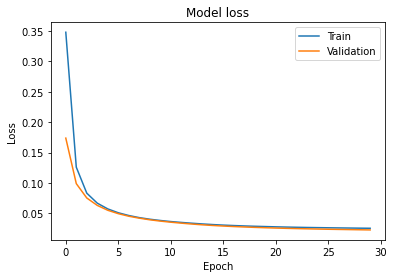

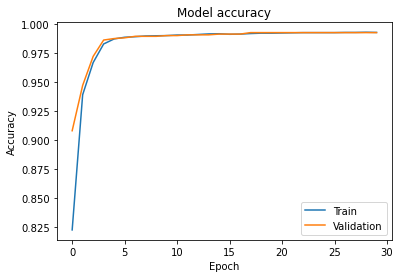

In [54]:
print_result(classifier2)

## Koriscenje categorical_hinge loss funkcije

In [55]:
# radi dobro kada je u poslednjem sloju tanh aktivaciona funkcija
classifier3 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='tanh'),])

classifier3.compile(optimizer='sgd',  
                    loss='categorical_hinge', 
                    metrics=['accuracy'])

hist = classifier3.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

Epoch 1/30
79/79 [==============================] - 1s 10ms/step - loss: 0.8354 - accuracy: 0.7788 - val_loss: 0.3750 - val_accuracy: 0.8268
Epoch 2/30
79/79 [==============================] - 1s 7ms/step - loss: 0.3311 - accuracy: 0.8247 - val_loss: 0.2305 - val_accuracy: 0.8842
Epoch 3/30
79/79 [==============================] - 1s 7ms/step - loss: 0.2008 - accuracy: 0.8923 - val_loss: 0.1471 - val_accuracy: 0.9364
Epoch 4/30
79/79 [==============================] - 1s 8ms/step - loss: 0.1197 - accuracy: 0.9570 - val_loss: 0.1013 - val_accuracy: 0.9769
Epoch 5/30
79/79 [==============================] - 1s 9ms/step - loss: 0.0826 - accuracy: 0.9857 - val_loss: 0.0790 - val_accuracy: 0.9836
Epoch 6/30
79/79 [==============================] - 1s 7ms/step - loss: 0.0680 - accuracy: 0.9862 - val_loss: 0.0663 - val_accuracy: 0.9841
Epoch 7/30
79/79 [==============================] - 1s 7ms/step - loss: 0.0551 - accuracy: 0.9881 - val_loss: 0.0582 - val_accuracy: 0.9851
Epoch 8/30
79/79 [=

61/61 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9908


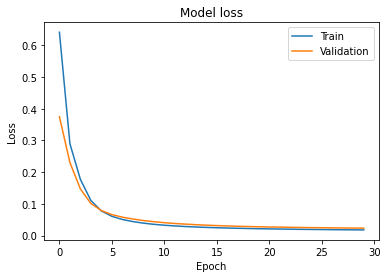

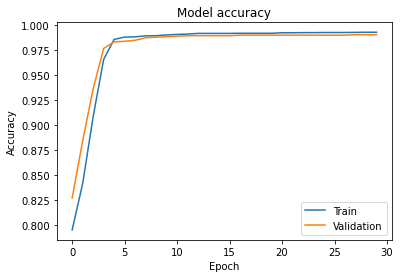

In [56]:
print_result(classifier3)

## Modifikacija MSE loss funckije

In [57]:
classifier4 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='sigmoid'),])

#begin_tensor = tf.convert_to_tensor([0, 0, 0, 0], dtype=tf.int32)

# modifikovana MSE loss funcija, i ako MSE odgovara regresiji, a ne klasifikaciji
# u sustini jedina razlika jeste ta da se razlika izmedju stvarne vrednisti i predvidjene
# deli sa 10. Na taj nacin se dobija da se smanjuje magnituda gubitaka sto moze biti korisno
# u situacijama kada je MSE velika
# shape y_pred jeste [32,1] jer je prva dimenzija uvek jednaka velicini batch_size a druga 
# broju izlaznih cvorova. Funkcija uvek treba da vrati vektor duzine batch_size
def custom_mse_loss(y_actual, y_pred):
    y_actual = tf.dtypes.cast(y_actual, tf.float32)
    loss = K.mean(K.sum(K.square((y_actual-y_pred)/10.)))
    return loss

classifier4.compile(optimizer='sgd',  
                    loss=custom_mse_loss, 
                    metrics=['accuracy'])

hist = classifier4.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

Epoch 1/30
79/79 [==============================] - 1s 8ms/step - loss: 0.1730 - accuracy: 0.7976 - val_loss: 0.1558 - val_accuracy: 0.7893
Epoch 2/30
79/79 [==============================] - 0s 5ms/step - loss: 0.1479 - accuracy: 0.7918 - val_loss: 0.1382 - val_accuracy: 0.7899
Epoch 3/30
79/79 [==============================] - 0s 5ms/step - loss: 0.1311 - accuracy: 0.7902 - val_loss: 0.1247 - val_accuracy: 0.7955
Epoch 4/30
79/79 [==============================] - 0s 5ms/step - loss: 0.1193 - accuracy: 0.8055 - val_loss: 0.1135 - val_accuracy: 0.8452
Epoch 5/30
79/79 [==============================] - 0s 5ms/step - loss: 0.1075 - accuracy: 0.8627 - val_loss: 0.1039 - val_accuracy: 0.8795
Epoch 6/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0983 - accuracy: 0.8880 - val_loss: 0.0958 - val_accuracy: 0.8949
Epoch 7/30
79/79 [==============================] - 0s 5ms/step - loss: 0.0920 - accuracy: 0.9091 - val_loss: 0.0887 - val_accuracy: 0.9062
Epoch 8/30
79/79 [==

61/61 [==============================] - 0s 3ms/step - loss: 0.0074 - accuracy: 0.9764


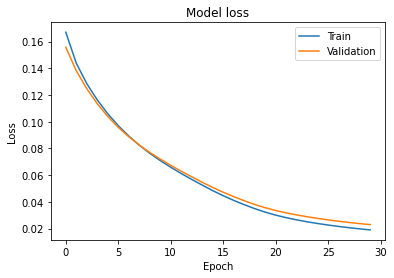

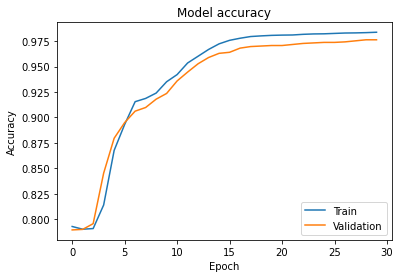

In [58]:
print_result(classifier4)

##  Sign penalty loss funkcija

In [59]:
# najpre se proverava da li znak predikcije i stvarne vrednosti razlicit
# ako jeste to je promasaj znaka i taj slucaj se kaznjava tako sto se mnozi sa 10
# ako su predikcija i stvarna vrednost istog znaka, nema kaznjavanja
# vraca srednju vrednost gresaka
def sign_penalty(y_actual, y_pred):
    y_actual = tf.dtypes.cast(y_actual, tf.float32)
    penalty = 10.
    loss = tf.where(tf.less(y_actual * y_pred, 0), \
                     penalty * tf.square(y_actual - y_pred), \
                     tf.square(y_actual - y_pred))
    return tf.reduce_mean(loss, axis=-1)

classifier5 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='sigmoid'),])

classifier5.compile(optimizer='sgd',  
                    loss=sign_penalty, 
                    metrics=['accuracy'])

hist = classifier5.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

Epoch 1/30
79/79 [==============================] - 1s 9ms/step - loss: 0.1771 - accuracy: 0.7857 - val_loss: 0.1547 - val_accuracy: 0.7893
Epoch 2/30
79/79 [==============================] - 0s 6ms/step - loss: 0.1450 - accuracy: 0.7899 - val_loss: 0.1318 - val_accuracy: 0.7893
Epoch 3/30
79/79 [==============================] - 1s 7ms/step - loss: 0.1229 - accuracy: 0.7922 - val_loss: 0.1144 - val_accuracy: 0.7893
Epoch 4/30
79/79 [==============================] - 1s 7ms/step - loss: 0.1090 - accuracy: 0.7866 - val_loss: 0.1003 - val_accuracy: 0.8186
Epoch 5/30
79/79 [==============================] - 1s 7ms/step - loss: 0.0935 - accuracy: 0.8424 - val_loss: 0.0883 - val_accuracy: 0.9006
Epoch 6/30
79/79 [==============================] - 1s 6ms/step - loss: 0.0849 - accuracy: 0.9107 - val_loss: 0.0781 - val_accuracy: 0.9549
Epoch 7/30
79/79 [==============================] - 1s 7ms/step - loss: 0.0735 - accuracy: 0.9652 - val_loss: 0.0695 - val_accuracy: 0.9733
Epoch 8/30
79/79 [==

61/61 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9897


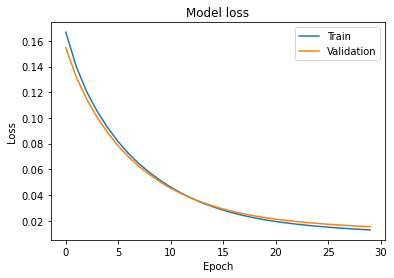

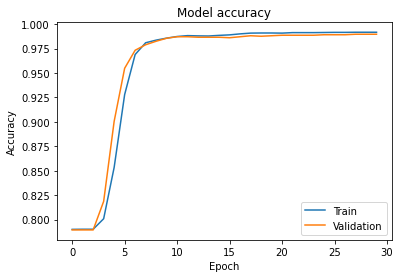

In [60]:
print_result(classifier5)

## Loss funkcija 6

In [61]:
classifier6 = Sequential([Dense(NODES1, activation='relu', input_dim=INPUT_DIM),
                          Dense(NODES2, activation='relu'), 
                          Dense(1, activation='sigmoid'),])

# keepsdims ako se ne stavi true smanjuje dim za 1
def custom_loss(y_actual, y_pred):
    y_actual = tf.dtypes.cast(y_actual, tf.float32)
    nb_devide = K.sqrt(K.sum(K.square(y_pred),axis = 1, keepdims=True))
    predicted = y_pred / nb_devide
    return K.sum(K.square(y_actual - predicted))

classifier6.compile(optimizer='sgd',  
                    loss=custom_loss, 
                    metrics=['accuracy'])

hist = classifier6.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

Epoch 1/30
79/79 [==============================] - 1s 9ms/step - loss: 79.3794 - accuracy: 0.7938 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 2/30
79/79 [==============================] - 0s 6ms/step - loss: 78.7167 - accuracy: 0.7872 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 3/30
79/79 [==============================] - 0s 6ms/step - loss: 79.1395 - accuracy: 0.7914 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 4/30
79/79 [==============================] - 0s 6ms/step - loss: 78.9644 - accuracy: 0.7896 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 5/30
79/79 [==============================] - 0s 6ms/step - loss: 79.0034 - accuracy: 0.7900 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 6/30
79/79 [==============================] - 0s 6ms/step - loss: 79.6905 - accuracy: 0.7969 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 7/30
79/79 [==============================] - 0s 5ms/step - loss: 79.2168 - accuracy: 0.7922 - val_loss: 77.9795 - val_accuracy: 0.7893
Epoch 

61/61 [==============================] - 0s 4ms/step - loss: 25.2465 - accuracy: 0.7893


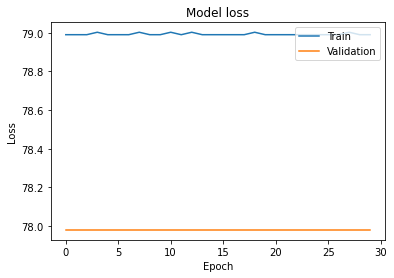

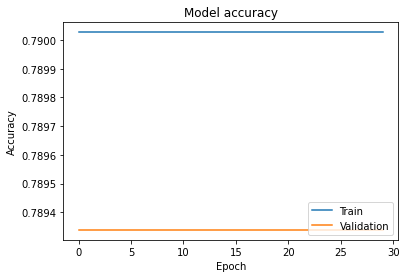

In [62]:
print_result(classifier6)

## Koriscenje adam(Adaptive Moment estimation) optimizatora
Adam algorotam je brzi i zauzima manje memorije od SGD koji je i dalje najkorisceniji. Kreiran je sa idejom da koristi prednosti RMSProp(Root Mean Square Propagation) i AdaGrad(Adaptive Gradient) algoritama.
<br>Pored koriscenja adam optimizatora koriscen je i dodatni dropout sloj koji se koristi za sprecavanje overfitting-a tako sto zanemaruje pojedine cvorove tokom treniranja.

In [63]:
classifier7 = Sequential()
classifier7.add(Dense(NODES1, activation='relu', input_dim=INPUT_DIM))
classifier7.add(Dense(NODES2, activation='relu'))
classifier7.add(layers.Dropout(0.3))
classifier7.add(Dense(1, activation='sigmoid'))

classifier7.compile(optimizer='adam',  
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

hist = classifier7.fit(X_train, Y_train, 
                       batch_size=BATCH_SIZE, epochs=EPOCHS,
                       validation_data=(X_test, Y_test))

Epoch 1/30
79/79 [==============================] - 2s 15ms/step - loss: 0.6861 - accuracy: 0.5361 - val_loss: 0.3888 - val_accuracy: 0.8411
Epoch 2/30
79/79 [==============================] - 1s 11ms/step - loss: 0.3438 - accuracy: 0.8772 - val_loss: 0.2001 - val_accuracy: 0.9518
Epoch 3/30
79/79 [==============================] - 1s 8ms/step - loss: 0.1856 - accuracy: 0.9437 - val_loss: 0.1282 - val_accuracy: 0.9651
Epoch 4/30
79/79 [==============================] - 1s 8ms/step - loss: 0.1267 - accuracy: 0.9624 - val_loss: 0.0935 - val_accuracy: 0.9739
Epoch 5/30
79/79 [==============================] - 1s 8ms/step - loss: 0.0931 - accuracy: 0.9739 - val_loss: 0.0711 - val_accuracy: 0.9790
Epoch 6/30
79/79 [==============================] - 0s 6ms/step - loss: 0.0688 - accuracy: 0.9864 - val_loss: 0.0569 - val_accuracy: 0.9856
Epoch 7/30
79/79 [==============================] - 1s 7ms/step - loss: 0.0641 - accuracy: 0.9834 - val_loss: 0.0490 - val_accuracy: 0.9877
Epoch 8/30
79/79 [

61/61 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9897


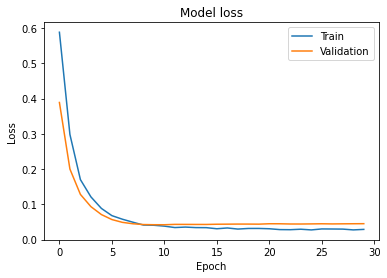

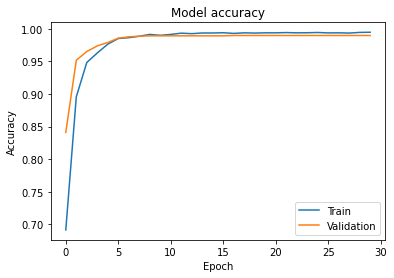

In [64]:
print_result(classifier7)